# <center> 5.4	Visualizing what convnets learn </center>
> 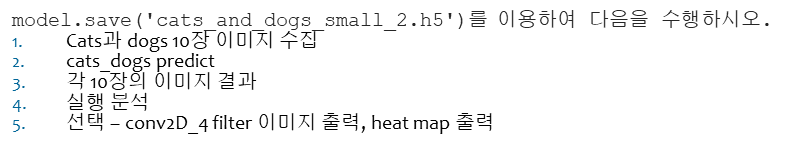

In [2]:
import keras
from keras.models import load_model
import os, shutil
import matplotlib.pyplot as plt
import numpy as np
from keras import models
from keras.preprocessing import image
model = load_model('cats_and_dogs_small_2.h5')

# 1. Cats과 dogs 10장 이미지 수집

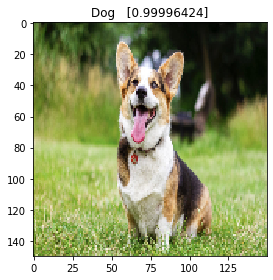

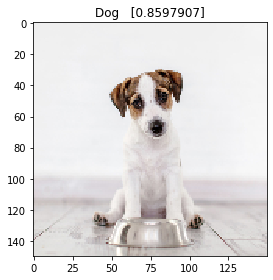

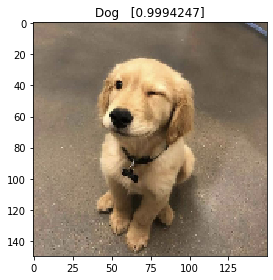

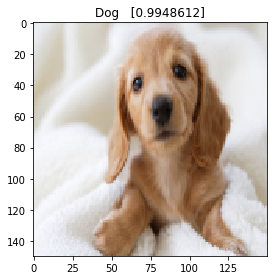

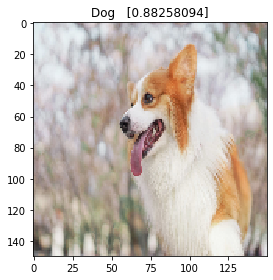

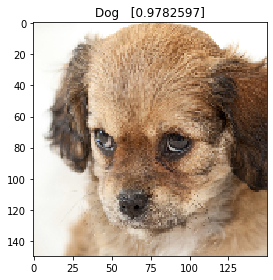

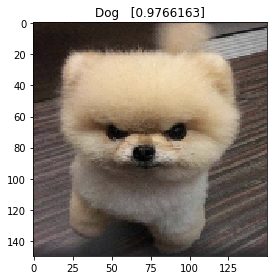

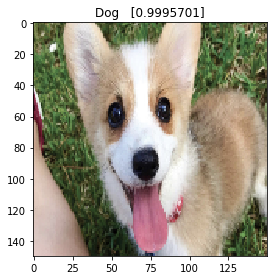

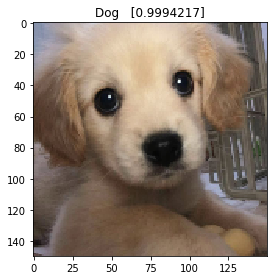

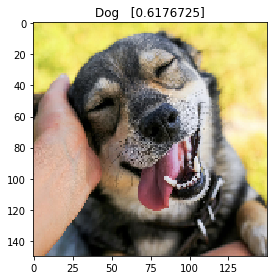

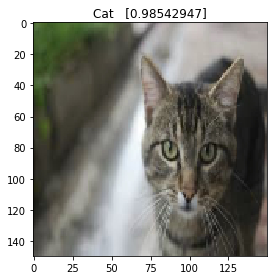

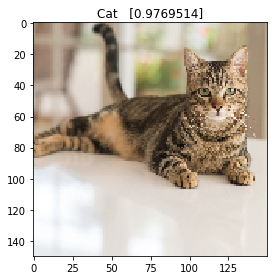

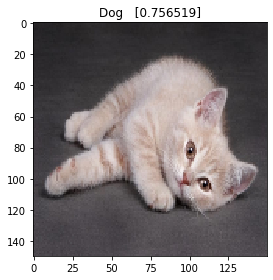

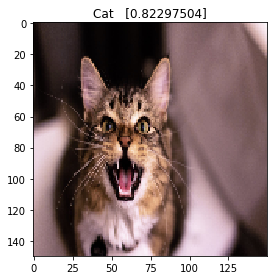

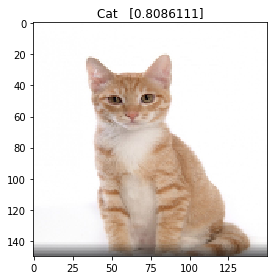

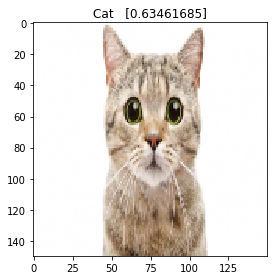

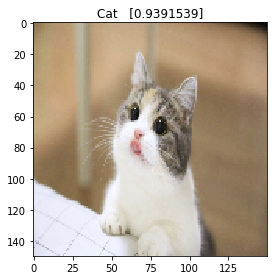

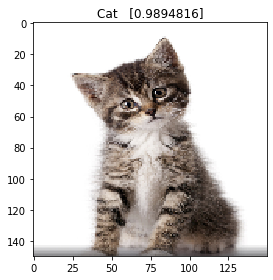

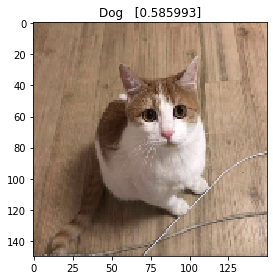

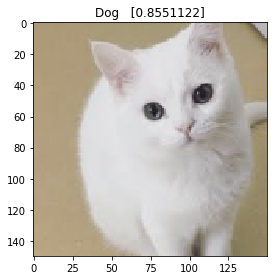

In [64]:
dir_path = './datasets/catdog/'

for i in range(1, 21):
    
    image_path = dir_path + str(i) + '.jpg'
    
    img = image.load_img(image_path, target_size=(150,150))

    # (150, 150, 3) 크기의 넘파이 float32 배열
    x = image.img_to_array(img)
    
    # 차원을 추가하여 (1, 150, 150, 3) 크기의 배치로 배열을 변환합니다
    x = np.expand_dims(x, axis=0)

    # 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
    x = x / 255.

    preds = model.predict(x)
        
    if preds[0] > 0.5:
        title_label = "Dog   " + str(preds[0])
    else:
        title_label = "Cat   " + str(1. - preds[0])
    
    ax = plt.figure()
    
    ax = plt.title(title_label)
    ax = plt.imshow(img)
    ax = plt.tight_layout()

    plt.show(ax)
    

In [46]:
model = load_model('cats_and_dogs_small_2.h5')

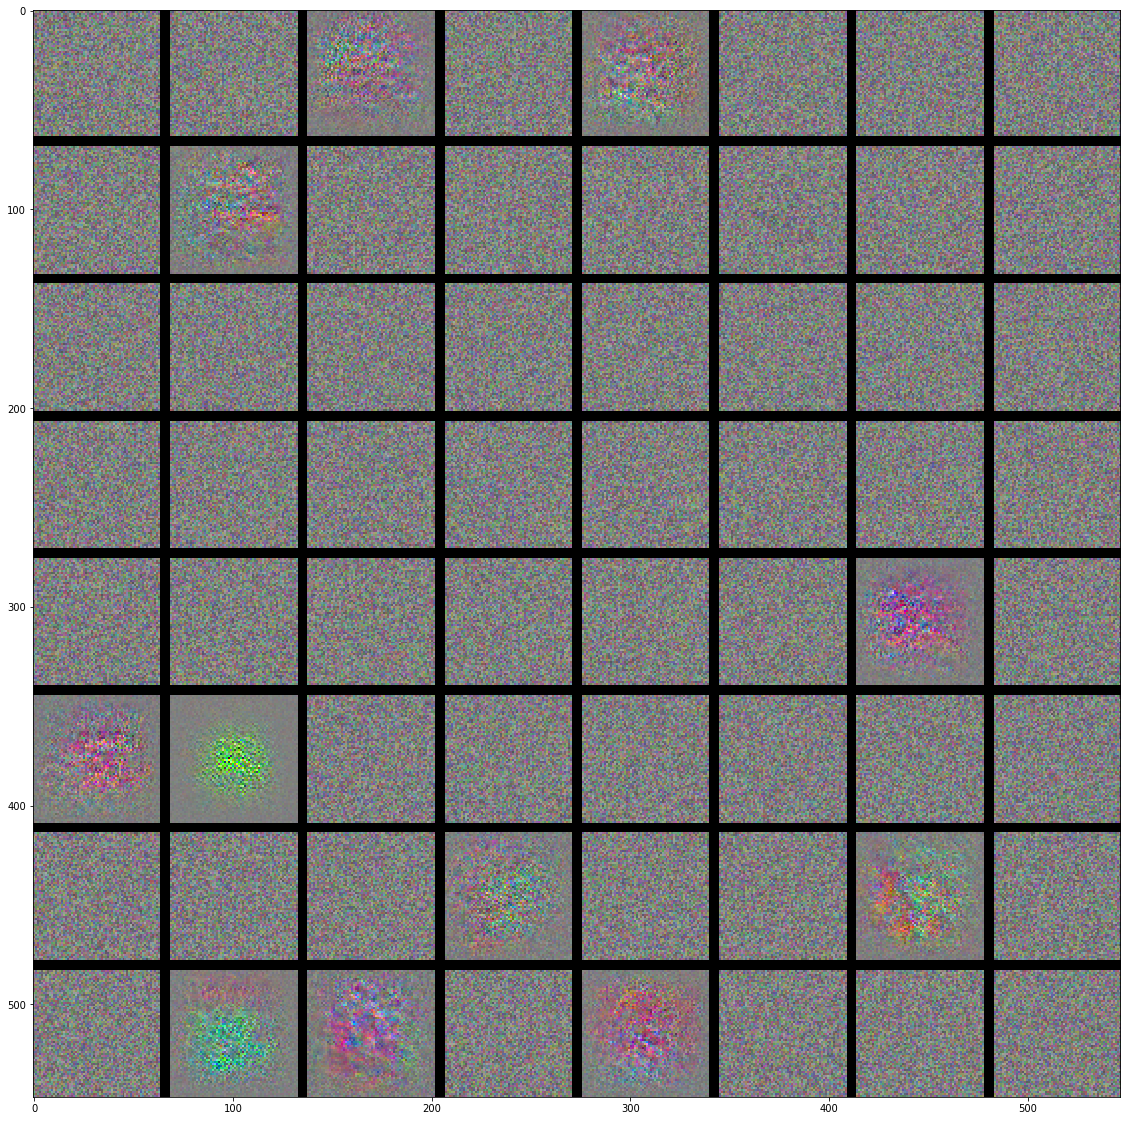

In [47]:
# 5. conv2d_ 4 filter 이미지 출력, heatmap 출력

import cv2
from keras.applications import VGG16
from keras import backend as K

layer_name = 'conv2d_8'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

# gradients 함수가 반환하는 텐서 리스트(여기에서는 크기가 1인 리스트)에서 첫 번째 텐서를 추출합니다
grads = K.gradients(loss, model.input)[0]

# 0 나눗셈을 방지하기 위해 1e–5을 더합니다
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss, grads])

# 테스트:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

# 잡음이 섞인 회색 이미지로 시작합니다
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# 업데이트할 그래디언트의 크기
step = 1.
for i in range(40):   # 경사 상승법을 40회 실행합니다
    # 손실과 그래디언트를 계산합니다
    loss_value, grads_value = iterate([input_img_data])
    # 손실을 최대화하는 방향으로 입력 이미지를 수정합니다
    input_img_data += grads_value * step

def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화합니다
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑합니다
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환합니다
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

layer_name = 'conv2d_8'
size = 64
margin = 5

# 결과를 담을 빈 (검은) 이미지
results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')
for i in range(8):  # results 그리드의 행을 반복합니다
    for j in range(8):  # results 그리드의 열을 반복합니다
        # layer_name에 있는 i + (j * 8)번째 필터에 대한 패턴 생성합니다
        filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

        # results 그리드의 (i, j) 번째 위치에 저장합니다
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

# results 그리드를 그립니다
plt.figure(figsize=(20, 20))
plt.imshow(results)
plt.show()
